In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/dataset.csv
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (123).jpg
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (10).jpg
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (179).jpg
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (352).jpg
/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw/512Glioma/glioma (130).j

Full dataset class distribution: Counter({0: 1501, 1: 1501, 2: 1501, 3: 1501})
Training set class distribution: Counter({1: 1051, 3: 1051, 0: 1050, 2: 1050})
Validation set class distribution: Counter({1: 150, 2: 150, 0: 150, 3: 150})
Test set class distribution: Counter({2: 301, 0: 301, 1: 300, 3: 300})
Using device: cuda


Epoch 1/10 - Validation: 100%|██████████| 75/75 [00:06<00:00, 12.17it/s]


Epoch 1/10, Train Loss: 0.3015, Train Acc: 89.81%, Val Loss: 0.0945, Val Acc: 96.50%


Epoch 2/10 - Validation: 100%|██████████| 75/75 [00:05<00:00, 14.40it/s]


Epoch 2/10, Train Loss: 0.1155, Train Acc: 96.48%, Val Loss: 0.0911, Val Acc: 97.00%


Epoch 3/10 - Validation: 100%|██████████| 75/75 [00:05<00:00, 14.18it/s]


Epoch 3/10, Train Loss: 0.0740, Train Acc: 97.91%, Val Loss: 0.0530, Val Acc: 98.67%


Epoch 4/10 - Validation: 100%|██████████| 75/75 [00:05<00:00, 13.56it/s]


Epoch 4/10, Train Loss: 0.0408, Train Acc: 98.88%, Val Loss: 0.0719, Val Acc: 98.17%


Epoch 5/10 - Validation: 100%|██████████| 75/75 [00:05<00:00, 13.44it/s]


Epoch 5/10, Train Loss: 0.0482, Train Acc: 98.43%, Val Loss: 0.0273, Val Acc: 99.67%


Epoch 6/10 - Validation: 100%|██████████| 75/75 [00:05<00:00, 14.22it/s]


Epoch 6/10, Train Loss: 0.0289, Train Acc: 99.29%, Val Loss: 0.0880, Val Acc: 98.00%


Epoch 7/10 - Validation: 100%|██████████| 75/75 [00:05<00:00, 13.91it/s]


Epoch 7/10, Train Loss: 0.0511, Train Acc: 98.55%, Val Loss: 0.0627, Val Acc: 98.00%


Epoch 8/10 - Validation: 100%|██████████| 75/75 [00:05<00:00, 14.23it/s]


Epoch 8/10, Train Loss: 0.0179, Train Acc: 99.55%, Val Loss: 0.0160, Val Acc: 99.67%


Epoch 9/10 - Validation: 100%|██████████| 75/75 [00:05<00:00, 13.80it/s]


Epoch 9/10, Train Loss: 0.0343, Train Acc: 98.93%, Val Loss: 0.0703, Val Acc: 98.17%


Epoch 10/10 - Validation: 100%|██████████| 75/75 [00:06<00:00, 12.03it/s]


Epoch 10/10, Train Loss: 0.0507, Train Acc: 98.50%, Val Loss: 0.0133, Val Acc: 99.33%
Training complete!


Testing: 100%|██████████| 151/151 [00:18<00:00,  8.19it/s]



Confusion Matrix:
                     Pred: 512Glioma  Pred: 512Meningioma  Pred: 512Normal  \
True: 512Glioma                  299                    2                0   
True: 512Meningioma                0                  300                0   
True: 512Normal                    0                    0              301   
True: 512Pituitary                 0                    0                0   

                     Pred: 512Pituitary  
True: 512Glioma                       0  
True: 512Meningioma                   0  
True: 512Normal                       0  
True: 512Pituitary                  300  

Classification Report:
               precision    recall  f1-score   support

    512Glioma       1.00      0.99      1.00       301
512Meningioma       0.99      1.00      1.00       300
    512Normal       1.00      1.00      1.00       301
 512Pituitary       1.00      1.00      1.00       300

     accuracy                           1.00      1202
    macro avg       1.00

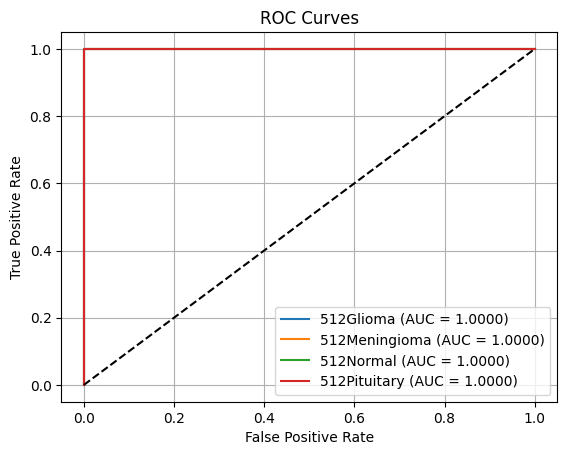

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision.models import AlexNet_Weights
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
from torchvision.models import densenet169, DenseNet169_Weights
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for 3 channels
])

# Load dataset using ImageFolder
dataset_root = "../dataset/Augmented/"  # To run it locally, change this to your dataset path
# dataset_root = "/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented Data/Augmented"  
dataset = ImageFolder(root=dataset_root, transform=transform)

# First split: train (70%) and temp (30%)
train_indices, temp_indices = train_test_split(
    range(len(dataset)),
    test_size=0.3,
    stratify=dataset.targets,
    random_state=42
)

# Second split: temp into validation (10% of total) and test (20% of total)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=2/3,  # 2/3 of 30% is 20% of the total dataset
    stratify=[dataset.targets[i] for i in temp_indices],
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Print class distribution in the full dataset
print("Full dataset class distribution:", Counter(dataset.targets))

# Print class distribution in the training set
train_labels = [dataset.targets[i] for i in train_indices]
print("Training set class distribution:", Counter(train_labels))

# Print class distribution in the validation set
val_labels = [dataset.targets[i] for i in val_indices]
print("Validation set class distribution:", Counter(val_labels))

# Print class distribution in the test set
test_labels = [dataset.targets[i] for i in test_indices]
print("Test set class distribution:", Counter(test_labels))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define model (DenseNet-169)
class DenseNet169Classifier(nn.Module):
    def __init__(self, num_classes=4):
        super(DenseNet169Classifier, self).__init__()
        # Load DenseNet-169 with pretrained weights
        self.model = densenet169(weights=DenseNet169_Weights.IMAGENET1K_V1)
        # Modify the classifier to match the number of output classes
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = DenseNet169Classifier(num_classes=4).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with validation
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # Training phase
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total * 100

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training complete!")

# Evaluate on test set
model.eval()
test_loss, correct, total = 0.0, 0, 0
all_labels = []
all_predictions = []
all_probabilities = []

# Reverse the class_to_idx mapping to get idx_to_class
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Collect all labels, predictions, and probabilities for metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct / total * 100

# Convert numeric predictions and labels to class names
all_labels_names = [idx_to_class[label] for label in all_labels]
all_predictions_names = [idx_to_class[pred] for pred in all_predictions]

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f"True: {label}" for label in dataset.classes],  # True labels
    columns=[f"Pred: {label}" for label in dataset.classes]  # Predicted labels
)

# Print metrics
print("\nConfusion Matrix:")
print(conf_matrix_df)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=dataset.classes))

# Calculate ROC and AUC for each class
print("\nROC and AUC Metrics:")
for i, class_name in enumerate(dataset.classes):
    true_binary = [1 if label == i else 0 for label in all_labels]  # Binary labels for the current class
    probabilities = [prob[i] for prob in all_probabilities]  # Probabilities for the current class

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_binary, probabilities)
    auc_score = roc_auc_score(true_binary, probabilities)
    print(f"Class '{class_name}': AUC = {auc_score:.4f}")

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.4f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [4]:
conf_matrix_df

,Pred: 512Glioma,Pred: 512Meningioma,Pred: 512Normal,Pred: 512Pituitary
True: 512Glioma,299,2,0,0
True: 512Meningioma,0,300,0,0
True: 512Normal,0,0,301,0
True: 512Pituitary,0,0,0,300
